In [3]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from generation import generate_from_total_pdf
from generation import generate_from_total_pdf
from generation import generate_from_total_pdf
from distributions import total_cdf, total_pdf
from distributions import total_cdf, total_pdf
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test
from hypothesis_test import signal_background_test
from hypothesis_test import signal_background_test

In [5]:
# True parameter values
true_params, alpha, beta = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}, 5, 5.6
random_shifts = {
    'f': np.random.uniform(-0.09, 0.5), 
    'lam': np.random.uniform(-0.3, 1), 
    'mu': np.random.uniform(-0.25, 0.3), 
    'sigma': np.random.uniform(-0.01, 0.03)
}
starting_params = {}
for param in true_params:
    starting_params[param] = true_params[param] + random_shifts[param]
    starting_params[param] = float(f'{starting_params[param]:.4}')

In [9]:
n_datapoints = 10
n_init = 2000
N = np.logspace(1, 6, num=n_datapoints).astype(int)
N = np.linspace(600, 1000, n_datapoints).astype(int)

all_data = [np.array([generate_from_total_pdf(N_events) for _ in range(n_init)]) for N_events in N]


In [10]:
def error_on_p(p, n):
    return np.sqrt((p*(1-p))/n)

### Hypothesis Testing

In [11]:
P = []
P_err = []
validities = []
ns = []
for i, group_i in enumerate(all_data):
    n_i = n_init

    r_discoveries = 0
    for dataset in group_i:

        discovery, _, _ = signal_background_test(dataset=dataset, pdf=total_pdf, cdf=total_cdf, binned=False, starting_params=starting_params)

        if discovery=='invalid minimum':
            n_i -= 1

        if discovery==True:
            r_discoveries += 1

    ns.append(n_i)

    p = r_discoveries/n_i
    P.append(p)
    P_err.append(error_on_p(p, n_i))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -799                       │              Nfcn = 158              │
│ EDM = 0.00672 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [12]:
# successes = []
# for N_i in Ns:
#     n_discoveries = 0
#     for _ in range(n_init):
#         dataset = generate_from_total_pdf(N_i)

#         discovery, _, _ = signal_background_test(dataset=dataset, cdf=total_cdf, starting_params=starting_params)

#         if discovery:
#             n_discoveries += 1
#     successes.append(n_discoveries)

# dict(zip(Ns, successes))

# Finding `N_90`

In [13]:
print(N)
print(P)
print(P_err)
N, P, P_err = np.array(N), np.array(P), np.array(P_err)

[ 600  644  688  733  777  822  866  911  955 1000]
[0.25, 0.2, 0.2, 0.35, 0.2631578947368421, 0.3, 0.3, 0.35, 0.35, 0.25]
[0.09682458365518543, 0.0894427190999916, 0.0894427190999916, 0.1066536450385077, 0.10102261788814665, 0.10246950765959598, 0.10246950765959598, 0.1066536450385077, 0.1066536450385077, 0.09682458365518543]


In [14]:
# import pickle 

# data_to_save = {
#     'N': N,
#     'P': P,
#     'P_err': P_err
# }

# # Save the data to a pickle file
# with open('PN_data.pkl', 'wb') as file:
#     pickle.dump(data_to_save, file)

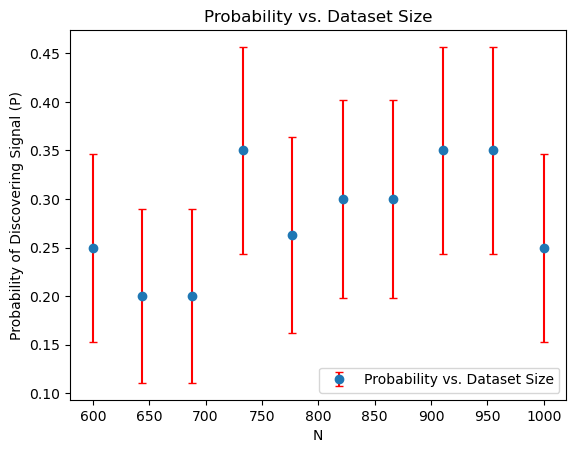

In [15]:
reduced_N = N*1e-5

fig, ax = plt.subplots()
ax.errorbar(N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

{'a': '(-4.83e-13, 3.02e-17)',
 'b': '(8.11e-08, 5.31e-12)',
 'c': '(-0.00445, 3.08e-07)',
 'd': '(79.8, 0.00593)'}

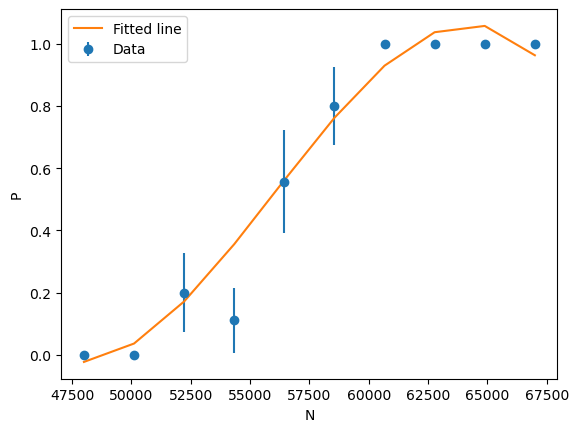

In [12]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def third_degree(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d 
def fourth_degree(x, a, b, c, d, e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*x + e

# Replace 0 uncertainties with 0.00001 so as to 
# not produce errors in the least squares estimation
P_err[P_err == 0.0] = 0.00001

# ------------------
# should maybe use starting values
# ------------------
popt, pcov = curve_fit(third_degree, N, P, sigma=P_err, absolute_sigma=True)

fig, ax = plt.subplots()

# Plotting
ax.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
ax.plot(N, third_degree(N, *popt), label='Fitted line')
ax.set_xlabel('N')
ax.set_ylabel('P')
ax.legend()

a, b, c, d = popt
a_err, b_err, c_err, d_err = np.sqrt(np.diag(pcov))

parameter_estimates = {
    'a': f'({a:.3}, {a_err:.3})',
    'b': f'({b:.3}, {b_err:.3})',
    'c': f'({c:.3}, {c_err:.3})',
    'd': f'({d:.3}, {d_err:.3})'
}

parameter_estimates

In [ ]:
# from iminuit import Minuit

# N = reduced_N

# # Define the linear model
# def linear_model(N, m, b):
#     return m * N + b

# # Define the chi-squared function
# def chi2_linear(m, b):
#     return np.sum(((P - linear_model(N, m, b)) / P_err) ** 2)

# # Perform the minimization
# mi = Minuit(chi2_linear, m=3, b=-1)
# mi.limits['b'] = (-3, 1)
# mi.limits['m'] = (1, 20)
# mi.errordef = Minuit.LEAST_SQUARES
# mi.migrad()  # finds minimum of chi-square function

# # Get parameters and errors
# m_fit = mi.values['m']
# b_fit = mi.values['b']
# m_err = mi.errors['m']
# b_err = mi.errors['b']

# # Plotting
# plt.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
# plt.plot(N, linear_model(N, *mi.values), label='Fitted line')
# plt.xlabel('N')
# plt.ylabel('P')
# plt.legend()
# plt.title('Linear Fit of P vs. N')
# plt.show()

# (m_fit, b_fit, m_err, b_err)